In [26]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
from bb.tools.hist_tools_modified import hist, poisson_error
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot, make_bb_plot_v2, make_hist_ratio_blackhole2
from bb.tools.bayesian_blocks_modified import bayesian_blocks
import bh_comp as bh_tools
import nllfitter.future_fitter as ff
from tqdm import tqdm_notebook
from scipy.stats import norm
import scipy.integrate as integrate
from collections import defaultdict
from lmfit import Model
from ROOT import gRandom, TF1
from bb.tools.fill_between_steps import fill_between_steps


%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [27]:
bb_dir  = os.path.join(os.path.dirname(bh_tools.__file__), '../..')
df_data_mul2 = pkl.load(open(bb_dir+'/files/BH/BH_test_data.p', 'rb'))
data_bg_mul2 = df_data_mul2[df_data_mul2.ST_mul2_BB >= 2800].ST_mul2_BB.values

df_data_mul8 = pkl.load(open(bb_dir+'/files/BH/BH_paper_data.p', 'rb'))
data_bg_mul8 = df_data_mul8[df_data_mul8.ST_mul8_BB >= 2800].ST_mul8_BB.values

bg_result, n_bg, be_bg = bh_tools.generate_initial_params(data_bg_mul2, data_bg_mul8)
sig_params = (8000,1000)
n_sig = 15
gRandom.SetSeed(20)

sig_pdf_ROOT = functools.partial(bh_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 2800, 13000, 2)
tf1_sig_pdf.SetParameters(*sig_params)

mc_sig = [tf1_sig_pdf.GetRandom() for i in xrange(n_sig)]
mc_bg = bh_tools.generate_toy_data(bg_result.x, n_bg)

be_sig = bayesian_blocks(mc_sig, p0=0.02)
#print be_sig
be_bg = np.concatenate([be_bg[be_bg < be_sig[0]-1.5], be_sig, be_bg[be_bg > be_sig[-1]+1.5]])
be_bg = np.linspace(2800,13000,53)

true_bg_bc_bb  = []
true_sig_bc_bb = []

for i in range(len(be_bg)-1):
    true_bg, _   = integrate.quad(functools.partial(bh_tools.bg_pdf, a=bg_result.x), be_bg[i], be_bg[i+1])
    true_bg_bc_bb.append(true_bg)
        
    true_sig, _  = integrate.quad(functools.partial(bh_tools.sig_pdf, a=sig_params), be_bg[i], be_bg[i+1])
    true_sig_bc_bb.append(true_sig)
n_tot = n_bg+n_sig

Performing fit with initial parameters:
alpha	= -18.081
beta	= -0.082
gamma	= 0.806
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
alpha	= 13.350 +/- 7112.860
beta	= -6.638 +/- 7096.169
gamma	= 1.786 +/- 0.905


CORRELATION MATRIX
------------------
[[ 1.     1.     0.991]
 [ 1.     1.     0.99 ]
 [ 0.991  0.99   1.   ]]


[  2800.      2931.765   3376.502   3899.849   5333.289  13000.   ]


In [28]:
a_init = 0.0001
init_fit = np.asarray(true_bg_bc_bb)*n_tot*(1-a_init)+np.asarray(true_sig_bc_bb)*n_tot*(a_init)
bc, _ = np.histogram(mc_bg+mc_sig, be_bg, range=(2800, 13000))
template_pdf = bh_tools.template_pdf_wrapper(true_bg_bc_bb, true_sig_bc_bb)
print template_pdf
template_model = ff.Model(template_pdf, ['A', 'ntot'])
template_model.set_bounds([(0,1), (n_tot, n_tot)])
template_fitter = ff.NLLFitter(template_model, bc)
template_res = template_fitter.fit([a_init, n_tot])
bg_frac_bc = np.asarray(true_bg_bc_bb)*n_tot*(1-template_res.x[0])
sig_frac_bc = np.asarray(true_sig_bc_bb)*n_tot*(template_res.x[0])
best_fit = bg_frac_bc+sig_frac_bc
 

<function template_pdf at 0x125ea0758>
Performing fit with initial parameters:
A	= 0.000
ntot	= 151.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
A	= 0.099 +/- 0.024
ntot	= 151.000 +/- 12.288


CORRELATION MATRIX
------------------
[[  1.000e+00  -7.376e-11]
 [ -7.376e-11   1.000e+00]]




number of signal events 14.885485474


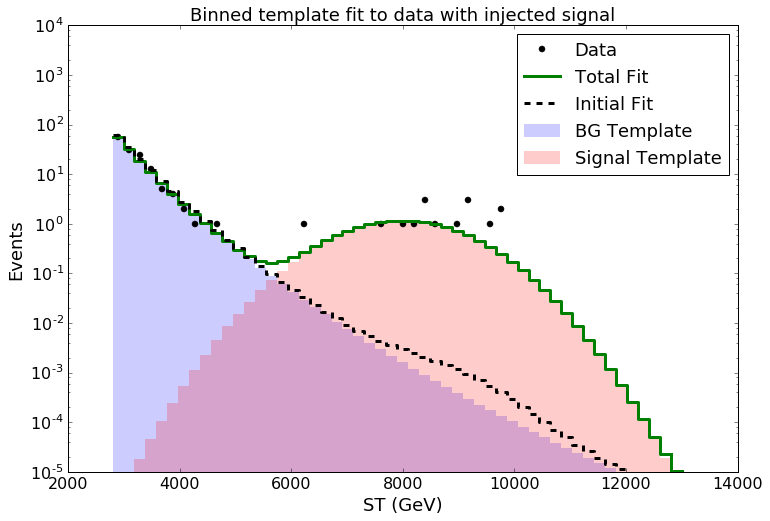

In [29]:
fig, ax = plt.subplots()
bin_centers = bin_centres = (be_bg[:-1] + be_bg[1:])/2.
#bin_widths = be[1:]-be[:-1]
ax.plot(bin_centers, bc, 'ko', label='Data')
fill_between_steps(ax, be_bg, bg_frac_bc, -2, alpha=0.2, step_where='pre',linewidth=1, color='b', label='BG Template')
fill_between_steps(ax, be_bg, sig_frac_bc, -2, alpha=0.2, step_where='pre',linewidth=1, color='r', label='Signal Template')
ax.step(be_bg[:-1], best_fit, linewidth=3, linestyle='-', color='g', where='post', label='Total Fit')
ax.step(be_bg[-2:], best_fit[-2:], linewidth=3, linestyle='-', color='g', where='pre')
ax.step(be_bg[:-1], init_fit, linewidth=3, linestyle='--', color='k', where='post', label='Initial Fit')
ax.step(be_bg[-2:], init_fit[-2:], linewidth=3, linestyle='--', color='k', where='pre')
plt.xlabel('ST (GeV)')
plt.ylabel('Events')
plt.title('Binned template fit to data with injected signal')
plt.legend()

plt.yscale('log', nonposy='clip')
ax.set_ylim(1e-5,1e4)
print 'number of signal events', n_tot*(template_res.x[0])
